### Loading the packages

In [11]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# scikit-learn functions
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA, NMF

# TensorFlow / Keras functions
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import cifar10

### Loading the CIFAR-10 data

In [19]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('X shapes: ', X_train.shape, X_test.shape)
print('y shapes: ', y_train.shape, y_test.shape)

X shapes:  (50000, 32, 32, 3) (10000, 32, 32, 3)
y shapes:  (50000, 1) (10000, 1)


### EDA and Preprocessing

In [20]:
# labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Filter training and test sets to 2 images
frog = 6
ship = 8
train_ind = np.where((y_train == frog) | (y_train == ship))[0]
test_ind = np.where((y_test == frog) | (y_test == ship))[0]
y_train = y_train[train_ind]
X_train = X_train[train_ind]
y_test = y_test[test_ind]
X_test = X_test[test_ind]

# Relabel frog as 0 and ship as 1 for binary classification
y_train[y_train == frog] = 0
y_train[y_train == ship] = 1
y_test[y_test == frog] = 0
y_test[y_test == ship] = 1

# Create validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.5, stratify=y_train, random_state=1)

# Printing the shapes
print('X shapes: ', X_train.shape, X_valid.shape, X_test.shape)
print('y shapes: ', y_train.shape, y_valid.shape, y_test.shape)

X shapes:  (5000, 32, 32, 3) (5000, 32, 32, 3) (2000, 32, 32, 3)
y shapes:  (5000, 1) (5000, 1) (2000, 1)


In [36]:
# Reshaping the data
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# reshaping the output parameter to 1-D array
y_train = y_train.ravel()

print('X shapes: ', X_train.shape, X_valid.shape, X_test.shape)
print('y shapes: ', y_train.shape, y_valid.shape, y_test.shape)

X shapes:  (5000, 3072) (5000, 3072) (2000, 3072)
y shapes:  (5000,) (5000, 1) (2000, 1)


In [37]:
# Standardizing the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [38]:
# Applying Demention Reduction PCA
pca = PCA(n_components=100, random_state=1)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_valid = pca.transform(X_valid)
print('X shapes: ', X_train.shape, X_valid.shape, X_test.shape)

X shapes:  (5000, 100) (5000, 100) (2000, 100)


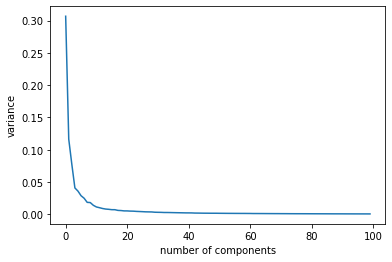

In [17]:
# Scree plot of the principal components (explained variance vs. number of components)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('variance')
plt.show()

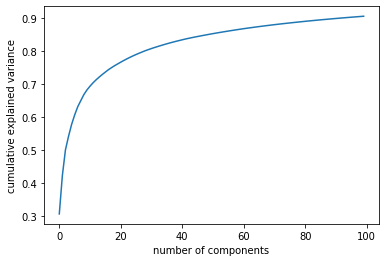

In [18]:
# Scree plot of cumulative explained variance vs. number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

According to the above graphs with 100 components we will have %90 of variation explained. So will use 100 components for the rest of this project.

### Initial KNN

In [39]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [40]:
preds_knn = knn.predict(X_test)
print('KNN accuracy: {:.3f}'.format(accuracy_score(y_test, preds_knn)))

KNN accuracy: 0.911


### Optimized KNN

In [9]:
knn = KNeighborsClassifier()
ks = np.arange(2, 7)
gs = GridSearchCV(knn, param_grid={'n_neighbors':ks}, scoring='accuracy', cv = 5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([2, 3, 4, 5, 6])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [10]:
gs.best_params_

{'n_neighbors': 3}

In [11]:
preds = gs.predict(X_test)
print('KNN accuracy: {:.3f}'.format(accuracy_score(y_test, preds)))

KNN accuracy: 0.914


### Initial Random Forest

In [20]:
rf = RandomForestClassifier(n_estimators  = 100)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
preds = rf.predict(X_test)
print('Random Forest accuracy: {:.3f}'.format(accuracy_score(y_test, preds)))

Random Forest accuracy: 0.922


### Optimized Random Forest

In [22]:
rf = RandomForestClassifier()
trees = [100, 200, 300]
depths = [6, 7, 8]
gs = GridSearchCV(rf, param_grid={'n_estimators':trees, 'max_depth':depths},
scoring='accuracy', cv = 5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [23]:
gs.best_params_

{'max_depth': 8, 'n_estimators': 300}

In [16]:
preds = gs.predict(X_test)
print('Random Forest accuracy: {:.3f}'.format(accuracy_score(y_test, preds)))

Random Forest accuracy: 0.924


### Initial Gradient Boosted

In [17]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [18]:
preds = gb.predict(X_test)
print('Gradient Boosting accuracy: {:.3f}'.format(accuracy_score(y_test, preds)))

Gradient Boosting accuracy: 0.928


### Optimized Gradient Boosted

In [19]:
gb = GradientBoostingClassifier()
trees = [200, 300]
learning = [.05, .1, .2]
gs = GridSearchCV(gb, param_grid={'n_estimators':trees, 'learning_rate':learning},
scoring='accuracy', cv = 5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [20]:
gs.best_params_

{'learning_rate': 0.1, 'n_estimators': 300}

In [21]:
preds = gs.predict(X_test)
print('Gradient Boosting accuracy: {:.3f}'.format(accuracy_score(y_test, preds)))

Gradient Boosting accuracy: 0.933


### Changing the shape of y_train for Neural Net

In [38]:
y_train = y_train.reshape(-1, 1)

### Initial Neural Net

In [39]:
model1 = Sequential()
model1.add(Dense(50, activation='relu', input_shape=(X_train.shape[1], )))
model1.add(Dense(10, activation='relu'))
model1.add(Dense(10, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

model1.fit(X_train, y_train, epochs=20, batch_size=50,
           validation_data=(X_valid, y_valid), verbose = 2)

model1.evaluate(X_test, y_test, verbose = 2)

Train on 5000 samples, validate on 5000 samples
Epoch 1/20
5000/5000 - 1s - loss: 0.5289 - accuracy: 0.7608 - val_loss: 0.2885 - val_accuracy: 0.8844
Epoch 2/20
5000/5000 - 0s - loss: 0.2202 - accuracy: 0.9180 - val_loss: 0.2215 - val_accuracy: 0.9170
Epoch 3/20
5000/5000 - 0s - loss: 0.1659 - accuracy: 0.9380 - val_loss: 0.2120 - val_accuracy: 0.9226
Epoch 4/20
5000/5000 - 0s - loss: 0.1421 - accuracy: 0.9486 - val_loss: 0.2036 - val_accuracy: 0.9266
Epoch 5/20
5000/5000 - 0s - loss: 0.1216 - accuracy: 0.9566 - val_loss: 0.2028 - val_accuracy: 0.9284
Epoch 6/20
5000/5000 - 0s - loss: 0.1060 - accuracy: 0.9644 - val_loss: 0.2043 - val_accuracy: 0.9316
Epoch 7/20
5000/5000 - 0s - loss: 0.0922 - accuracy: 0.9710 - val_loss: 0.2078 - val_accuracy: 0.9304
Epoch 8/20
5000/5000 - 0s - loss: 0.0814 - accuracy: 0.9744 - val_loss: 0.2140 - val_accuracy: 0.9306
Epoch 9/20
5000/5000 - 0s - loss: 0.0712 - accuracy: 0.9798 - val_loss: 0.2082 - val_accuracy: 0.9282
Epoch 10/20
5000/5000 - 0s - loss:

[0.2697342637479305, 0.938]

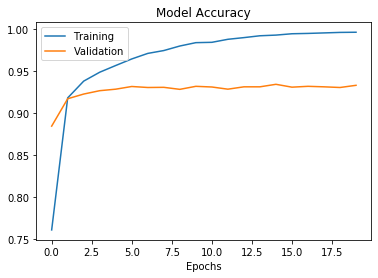

In [40]:
history = model1.history.history
plt.title('Model Accuracy')
plt.plot(history['accuracy'], label='Training')
plt.plot(history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### Optimized Neural Net

In [41]:
model2 = Sequential()
model2.add(Dense(50, activation='relu', input_shape=(X_train.shape[1], ), 
                 kernel_regularizer=keras.regularizers.l1(.001)))
model2.add(Dropout(rate=.5))
model2.add(Dense(10, activation='relu',
                 kernel_regularizer=keras.regularizers.l1(.001)))
model2.add(Dropout(rate=.5))
model2.add(Dense(10, activation='relu',
                 kernel_regularizer=keras.regularizers.l1(.001)))
model2.add(Dropout(rate=.5))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model2.fit(X_train, y_train, epochs=100, batch_size=50,
          validation_data=(X_valid, y_valid),
          callbacks=[early_stopping], verbose = 2)

model2.evaluate(X_test, y_test, verbose = 2)

Train on 5000 samples, validate on 5000 samples
Epoch 1/100
5000/5000 - 1s - loss: 2.1437 - accuracy: 0.5434 - val_loss: 1.1295 - val_accuracy: 0.7738
Epoch 2/100
5000/5000 - 1s - loss: 1.4455 - accuracy: 0.5792 - val_loss: 1.1137 - val_accuracy: 0.8096
Epoch 3/100
5000/5000 - 1s - loss: 1.2802 - accuracy: 0.6116 - val_loss: 1.1001 - val_accuracy: 0.8136
Epoch 4/100
5000/5000 - 1s - loss: 1.2067 - accuracy: 0.6272 - val_loss: 1.0765 - val_accuracy: 0.8288
Epoch 5/100
5000/5000 - 1s - loss: 1.1427 - accuracy: 0.6322 - val_loss: 1.0395 - val_accuracy: 0.8336
Epoch 6/100
5000/5000 - 1s - loss: 1.0933 - accuracy: 0.6656 - val_loss: 0.9850 - val_accuracy: 0.8414
Epoch 7/100
5000/5000 - 1s - loss: 1.0087 - accuracy: 0.7046 - val_loss: 0.9000 - val_accuracy: 0.8544
Epoch 8/100
5000/5000 - 1s - loss: 0.9774 - accuracy: 0.7296 - val_loss: 0.8416 - val_accuracy: 0.8570
Epoch 9/100
5000/5000 - 1s - loss: 0.8988 - accuracy: 0.7530 - val_loss: 0.7652 - val_accuracy: 0.8728
Epoch 10/100
5000/5000 - 

[0.25987746596336364, 0.941]

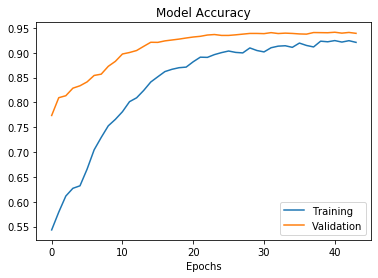

In [42]:
history = model2.history.history
plt.title('Model Accuracy')
plt.plot(history['accuracy'], label='Training')
plt.plot(history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### Preprocessing data for Convolutional Neural Net

In [30]:
X_train = pca.inverse_transform(X_train)
X_test = pca.inverse_transform(X_test)
X_valid = pca.inverse_transform(X_valid)

In [31]:
X_train = X_train.reshape(-1, 32, 32, 3)
X_valid = X_valid.reshape(-1, 32, 32, 3)
X_test = X_test.reshape(-1, 32, 32, 3)
print('X shapes: ', X_train.shape, X_valid.shape, X_test.shape)

X shapes:  (5000, 32, 32, 3) (5000, 32, 32, 3) (2000, 32, 32, 3)


### Initial Convolutional Neural Net

In [45]:
model3 = Sequential()
model3.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 padding='same', input_shape=(32,32,3)))

model3.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model3.add(Flatten())
model3.add(Dense(1, activation='sigmoid'))
model3.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
model3.fit(X_train, y_train, epochs=20, batch_size=10, 
           validation_data=(X_valid, y_valid), verbose = 2)
model3.evaluate(X_test, y_test, verbose = 2)

Train on 5000 samples, validate on 5000 samples
Epoch 1/20
5000/5000 - 3s - loss: 0.2191 - accuracy: 0.9142 - val_loss: 0.1868 - val_accuracy: 0.9298
Epoch 2/20
5000/5000 - 3s - loss: 0.1620 - accuracy: 0.9422 - val_loss: 0.1784 - val_accuracy: 0.9342
Epoch 3/20
5000/5000 - 3s - loss: 0.1427 - accuracy: 0.9502 - val_loss: 0.1530 - val_accuracy: 0.9424
Epoch 4/20
5000/5000 - 3s - loss: 0.1263 - accuracy: 0.9534 - val_loss: 0.1652 - val_accuracy: 0.9404
Epoch 5/20
5000/5000 - 3s - loss: 0.1147 - accuracy: 0.9600 - val_loss: 0.1513 - val_accuracy: 0.9432
Epoch 6/20
5000/5000 - 3s - loss: 0.1091 - accuracy: 0.9612 - val_loss: 0.1441 - val_accuracy: 0.9484
Epoch 7/20
5000/5000 - 3s - loss: 0.1044 - accuracy: 0.9600 - val_loss: 0.1425 - val_accuracy: 0.9474
Epoch 8/20
5000/5000 - 3s - loss: 0.0981 - accuracy: 0.9646 - val_loss: 0.1517 - val_accuracy: 0.9428
Epoch 9/20
5000/5000 - 3s - loss: 0.0941 - accuracy: 0.9660 - val_loss: 0.1427 - val_accuracy: 0.9528
Epoch 10/20
5000/5000 - 3s - loss:

[0.1358242617174983, 0.956]

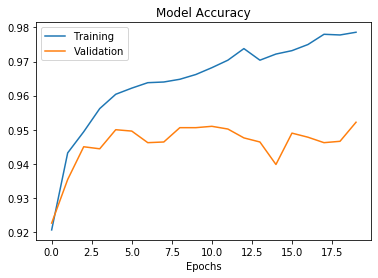

In [30]:
history = model3.history.history
plt.title('Model Accuracy')
plt.plot(history['accuracy'], label='Training')
plt.plot(history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### Optimized Convolutional Neural Net

In [34]:
model4 = Sequential()
model4.add(Conv2D(16, kernel_size=3, activation='relu', strides=1, 
                 padding='same', input_shape=(32,32,3),
                 kernel_regularizer=keras.regularizers.l2(.001)))
model4.add(Dropout(rate=.5))
model4.add(MaxPooling2D(pool_size=4, strides=2))

model4.add(Conv2D(32, kernel_size=3, activation='relu', 
                 padding='same',
                 kernel_regularizer=keras.regularizers.l2(.001)))
model4.add(Dropout(rate=.5))
model4.add(MaxPooling2D(pool_size=4, strides=3))

model4.add(Flatten())
model4.add(Dense(1, activation='sigmoid'))

model4.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model4.fit(X_train, y_train, epochs=200, batch_size=50, 
           validation_data=(X_valid, y_valid), verbose = 2, callbacks=[early_stopping])
model4.evaluate(X_test, y_test, verbose = 2)

Train on 5000 samples, validate on 5000 samples
Epoch 1/200
5000/5000 - 2s - loss: 0.2944 - accuracy: 0.8900 - val_loss: 0.4036 - val_accuracy: 0.9220
Epoch 2/200
5000/5000 - 1s - loss: 0.2112 - accuracy: 0.9306 - val_loss: 0.3595 - val_accuracy: 0.9338
Epoch 3/200
5000/5000 - 1s - loss: 0.1854 - accuracy: 0.9404 - val_loss: 0.3470 - val_accuracy: 0.9360
Epoch 4/200
5000/5000 - 1s - loss: 0.1746 - accuracy: 0.9444 - val_loss: 0.3248 - val_accuracy: 0.9410
Epoch 5/200
5000/5000 - 1s - loss: 0.1650 - accuracy: 0.9482 - val_loss: 0.3215 - val_accuracy: 0.9444
Epoch 6/200
5000/5000 - 1s - loss: 0.1527 - accuracy: 0.9498 - val_loss: 0.3142 - val_accuracy: 0.9422
Epoch 7/200
5000/5000 - 1s - loss: 0.1441 - accuracy: 0.9544 - val_loss: 0.2990 - val_accuracy: 0.9536
Epoch 8/200
5000/5000 - 1s - loss: 0.1437 - accuracy: 0.9542 - val_loss: 0.2972 - val_accuracy: 0.9496
Epoch 9/200
5000/5000 - 1s - loss: 0.1345 - accuracy: 0.9604 - val_loss: 0.2983 - val_accuracy: 0.9430
Epoch 10/200
5000/5000 - 

[0.22146977257728576, 0.965]

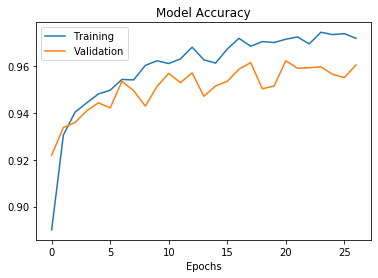

In [35]:
history = model4.history.history
plt.title('Model Accuracy')
plt.plot(history['accuracy'], label='Training')
plt.plot(history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.legend()
plt.show()